# Problems

- For 50M training samples, we see a negative mse for the training set. This is wierd, as the training set should always have a positive mse.
- For 1M training samples, we see behavior as expected.

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["HF_HOME"] = "/workspace/julian/hf_cache"
import sys
sys.path.append("..")
from pathlib import Path
import torch as th
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tools.utils import CCLatent
from tools.latent_scaler.utils import load_betas, load_stats, get_latent_from_idx
from tools.cc_utils import chat_only_latent_indices
from tools.paths import *

chat_indices = chat_only_latent_indices()

results_dir = DATA_ROOT / "results" / "closed_form_scalars" / "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04"

PLOTS = PLOTS / VERSION / "closed_form_scalers" / "Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04" / "beta_statistics"
PLOTS.mkdir(parents=True, exist_ok=True)

In [2]:
def to_array(df, skip_buckets = [0,4]):
    num_buckets = len(df["mean"][0].index)
    return np.stack([df["mean"][:, i].to_numpy() for i in range(num_buckets) if i not in skip_buckets])

def load_count_active(results_dir: Path, model_name: str, num_samples: int, n_offset: int = 0, special_results_dir: str = "", suffix: str = "", computation: str = "base_error", threshold_active_latents = None):
    if threshold_active_latents is not None:
        threshold_name = f"_jumprelu{threshold_active_latents}"
    else:
        threshold_name = ""
    if special_results_dir:
        count_active_path = results_dir / special_results_dir / model_name / f"count_active_{computation}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    else:
        count_active_path = results_dir / model_name / f"count_active_{computation}_N{num_samples}_n_offset{n_offset}{threshold_name}{suffix}.pt"
    return th.load(count_active_path, weights_only=True)


def plot_scalers_diff(betas, counts, name_a, computation_a, name_b, computation_b, relative: bool = False, log_scale_x: bool = False):
    if relative:
        diff = ((betas[computation_a][name_a] - betas[computation_b][name_b]).abs() / th.max(betas[computation_a][name_a], betas[computation_b][name_b])).abs()
    else:
        diff = (betas[computation_a][name_a] - betas[computation_b][name_b]).abs()
    counts_a = counts[computation_a][name_a]
    counts_b = counts[computation_b][name_b]
    counts_a = counts_a[~th.isnan(diff)]
    counts_b = counts_b[~th.isnan(diff)]
    diff = diff[~th.isnan(diff)]

    
    print("Max diff:", diff.max().item(), " Counts:", counts_a[diff.argmax()].item(), counts_b[diff.argmax()].item(), "Max Act:", get_latent_from_idx(diff.argmax(), diff, chat_indices, return_latent=True).max_act_unscaled)
    print("Median diff:", diff.median().item())
    print("Mean diff:", diff.mean().item())
    print("Min diff:", diff.min().item(), " Counts:", counts_a[diff.argmin()].item(), counts_b[diff.argmin()].item(), "Max Act:", get_latent_from_idx(diff.argmin(), diff, chat_indices, return_latent=True).max_act_unscaled)
    if log_scale_x:
        diff = th.log(diff)
    plt.hist(diff.cpu().numpy(), bins=100)
    plt.xlabel("Absolute Difference in Beta Values" if not log_scale_x else "Log Absolute Difference in Beta Values")
    plt.ylabel("Count")
    plt.title(f"Distribution of Differences Between {name_a} ({computation_a}) and {name_b} ({computation_b})")
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
    return plt


def to_array_fn(data):
    if isinstance(data, dict):
        return to_array(pd.DataFrame(data))
    else:
        return data

def plot_stats_buckets(stats, name, computation: str, show_train: bool = True, show_val: bool = True):
    SAME_Y = True
    stats = stats[computation]
    if show_train:
        mse_buckets_train = to_array_fn(stats[name + "-train"]["mse_buckets"]) 
        mse_buckets_before_train = to_array_fn(stats[name + "-train"]["mse_before_buckets"])
        perc_improvement_train = -(mse_buckets_train - mse_buckets_before_train) / mse_buckets_before_train

    mse_buckets_val = to_array_fn(stats[name + "-validation"]["mse_buckets"])
    mse_buckets_before_val = to_array_fn(stats[name + "-validation"]["mse_before_buckets"])
    perc_improvement_val = -(mse_buckets_val - mse_buckets_before_val) / mse_buckets_before_val

    if show_train:
        mse_buckets_train = to_array_fn(stats[name + "-train"]["mse_buckets"]) 
        mse_buckets_before_train = to_array_fn(stats[name + "-train"]["mse_before_buckets"])
        perc_improvement_train = -(mse_buckets_train - mse_buckets_before_train) / mse_buckets_before_train

    # Create histogram of differences between MSE buckets
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"MSE Percentage Improvement by Activation Bucket for {name} ({computation})")

    # Get max count across all buckets for consistent y-axis
    max_count = 0
    for i in range(3):
        if show_train:
            counts_train, _ = np.histogram(perc_improvement_train[i][~np.isnan(perc_improvement_train[i])], bins=100)
            max_count = max(max_count, counts_train.max())
        if show_val:
            counts_val, _ = np.histogram(perc_improvement_val[i][~np.isnan(perc_improvement_val[i])], bins=100)
            max_count = max(max_count, counts_val.max())

    bucket_labels = ["0-33%", "33-66%", "66-100%"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        if show_val:
            plt.hist(perc_improvement_val[i][~np.isnan(perc_improvement_val[i])], bins=100, alpha=0.5, label='Validation', color='blue')
        if show_train:
            plt.hist(perc_improvement_train[i][~np.isnan(perc_improvement_train[i])], bins=100, alpha=0.5, label='Train', color='red')
        plt.title(f"Bucket {bucket_labels[i]}")
        plt.xlabel("Percentage Improvement")
        plt.ylabel("Count")
        plt.legend()
        if SAME_Y:
            plt.ylim(0, max_count*1.1)

    plt.tight_layout()
    return plt

def get_negative_improvement_features(stats, name, split, threshold: float = 0.0):
    """
    Calculate which features have negative percentage improvement across all buckets.
    
    Args:
        stats: Dictionary containing MSE statistics
        name: Name of the experiment
        
    Returns:
        numpy array: Boolean mask indicating which features have negative improvement in all buckets
    """
    mse_buckets = to_array_fn(stats[name + "-" + split]["mse_buckets"])
    mse_buckets_before = to_array_fn(stats[name + "-" + split]["mse_before_buckets"])
    perc_improvement = -(mse_buckets - mse_buckets_before) / mse_buckets_before
    

    mse_overall = to_array_fn(stats[name + "-" + split]["mse"])
    mse_before_overall = to_array_fn(stats[name + "-" + split]["mse_before"])
    perc_improvement_overall = -(mse_overall - mse_before_overall) / mse_before_overall

    # Check if improvement is negative across all buckets
    is_negative = np.ones(perc_improvement.shape[1], dtype=bool)
    for bucket in range(perc_improvement.shape[0]):
        is_negative &= (perc_improvement[bucket] < threshold) & ~np.isnan(perc_improvement[bucket])

    # Print features with negative improvement
    if np.any(is_negative):
        print(f"\nFeatures with negative improvement (below {threshold}):")
        negative_indices = np.where(is_negative)[0]
        # Sort indices by overall improvement
        sorted_indices = sorted(negative_indices, key=lambda idx: perc_improvement_overall[idx])
        for idx in sorted_indices:
            improvements = [perc_improvement[bucket][idx] for bucket in range(perc_improvement.shape[0])]
            print(f"Feature {idx}: Improvements across buckets = {[f'{x:.3f}' for x in improvements]}")
            print(f"Overall improvement: {perc_improvement_overall[idx]:.3f}")
    return is_negative

def plot_betas(betas, count_active, name, computation: str, log_scale: bool = False):
    beta_values = betas[computation][name][betas[computation][name].isnan() == False].cpu().numpy()
    count_values = count_active[computation][name][betas[computation][name].isnan() == False].cpu().numpy()
    print(f"Min beta: {beta_values.min():.4f} Count: {count_values[beta_values.argmin()]}")
    print(f"Max beta: {beta_values.max():.4f} Count: {count_values[beta_values.argmax()]}")
    if log_scale:
        pos_beta_values = np.log10(beta_values[beta_values >= 0] + 1e-10)
        neg_beta_values = np.log10(-beta_values[beta_values < 0])
        
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        # Plot positive values on left y-axis
        n1, bins1, patches1 = ax1.hist(pos_beta_values, bins=100, alpha=0.5, color='blue', label="Positive Beta")
        ax1.set_ylabel('Count (Positive Beta)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        # Plot negative values on right y-axis  
        n2, bins2, patches2 = ax2.hist(neg_beta_values, bins=100, alpha=0.5, color='red', label="Negative Beta")
        ax2.set_ylabel('Count (Negative Beta)', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2)
    else:
        plt.figure()
        plt.hist(beta_values, bins=100)
    
    plt.xlabel("Beta values" if not log_scale else "Beta values (log scale)")
    plt.title(f"Distribution of beta values for {name} ({computation})")
    return plt
    
def plot_stats_mse(stats, name, computation="base_error", show_train: bool = True, show_val: bool = True, threshold: float = -1e-3):
    stats = stats[computation]
    if show_train:
        mse_train = to_array_fn(stats[name + "-train"]["mse_mean"])
        mse_before_train = to_array_fn(stats[name + "-train"]["mse_before_mean"])
        perc_improvement_train = -(mse_train - mse_before_train) / mse_before_train
        print(f"Train split has {np.sum((perc_improvement_train < threshold) & ~np.isnan(perc_improvement_train))} negative improvements")
        print(f"  Min:    {np.nanmin(perc_improvement_train).item():.5f}")
        print(f"  Max:    {np.nanmax(perc_improvement_train).item():.5f}")
        print(f"  Mean:   {np.nanmean(perc_improvement_train).item():.5f}")
        print(f"  Median: {np.nanmedian(perc_improvement_train).item():.5f}")

    if show_val:
        mse_val = to_array_fn(stats[name + "-validation"]["mse_mean"])
        mse_before_val = to_array_fn(stats[name + "-validation"]["mse_before_mean"])
        perc_improvement_val = -(mse_val - mse_before_val) / mse_before_val
        print(f"\nValidation split has {np.sum((perc_improvement_val < threshold) & ~np.isnan(perc_improvement_val))} negative improvements")
        print(f"  Min:    {np.nanmin(perc_improvement_val).item():.5f}")
        print(f"  Max:    {np.nanmax(perc_improvement_val).item():.5f}")
        print(f"  Mean:   {np.nanmean(perc_improvement_val).item():.5f}")
        print(f"  Median: {np.nanmedian(perc_improvement_val).item():.5f}")

    if show_train:
        plt.hist(perc_improvement_train, bins=100, alpha=0.5, label="Train", color="red")
    if show_val:
        plt.hist(perc_improvement_val, bins=100, alpha=0.5, label="Validation", color="blue")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Count")
    plt.title(f"Percentage Improvement for {name} ({computation})")
    plt.legend()
    return plt


In [7]:
# Load all scalers

def extract_count_active(betas_dict):
    if isinstance(next(iter(betas_dict.values())), dict):
        return {k: extract_count_active(v)[0] for k, v in betas_dict.items()}, {k: extract_count_active(v)[1] for k, v in betas_dict.items()}
    else:
        return {k: v[0] for k, v in betas_dict.items()}, {k: v[1]for k, v in betas_dict.items()}

betas = {
    "base_error": {
        "1M": load_betas(results_dir, 1_000_000, "base_error", 0),
        "5M": load_betas(results_dir, 5_000_000, "base_error", 0),
        "50M": load_betas(results_dir, 50_000_000, "base_error", 0),
    },
    "base_reconstruction": {
        "50M": load_betas(results_dir, 50_000_000, "base_reconstruction", 0),
    },
    "chat_error": {
        "50M": load_betas(results_dir, 50_000_000, "it_error", 0),
    },
    "chat_reconstruction": {
        "50M": load_betas(results_dir, 50_000_000, "it_reconstruction", 0),
    }
}

betas, count_active = extract_count_active(betas)

stats = {
    "base_error": {
        "1M-train": load_stats(results_dir, 1_000_000, 0, train=True, computation="base_error"),
        "1M-validation": load_stats(results_dir, 1_000_000, 0, train=False, computation="base_error"),
        "5M-train": load_stats(results_dir, 5_000_000, 0, train=True, computation="base_error"),
        "5M-validation": load_stats(results_dir, 5_000_000, 0, train=False, computation="base_error"),
        "50M-train": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=True, computation="base_error"),
        "50M-validation": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=False, computation="base_error"),
    },
    "base_reconstruction": {
        "50M-train": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=True, computation="base_reconstruction"),
        "50M-validation": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=False, computation="base_reconstruction"),
    },
    "chat_error": {
        "50M-train": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=True, computation="it_error"),
        "50M-validation": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=False, computation="it_error"),
    },
    "chat_reconstruction": {
        "50M-train": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=True, computation="it_reconstruction"),
        "50M-validation": load_stats(results_dir, 50_000_000, 0, suffix="_EVAL_N10000000_n_offset0", train=False, computation="it_reconstruction"),    
    }
}

/workspace/julian/repositories/representation-structure-comparison/notebooks/../tools/latent_scaler/utils.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load

Train split has 0 negative improvements
  Min:    -0.00000
  Max:    0.04507
  Mean:   0.00066
  Median: 0.00020

Validation split has 0 negative improvements
  Min:    -0.00000
  Max:    0.04511
  Mean:   0.00066
  Median: 0.00020


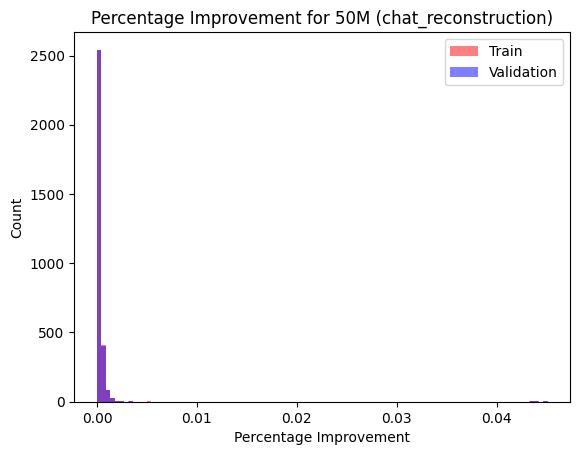

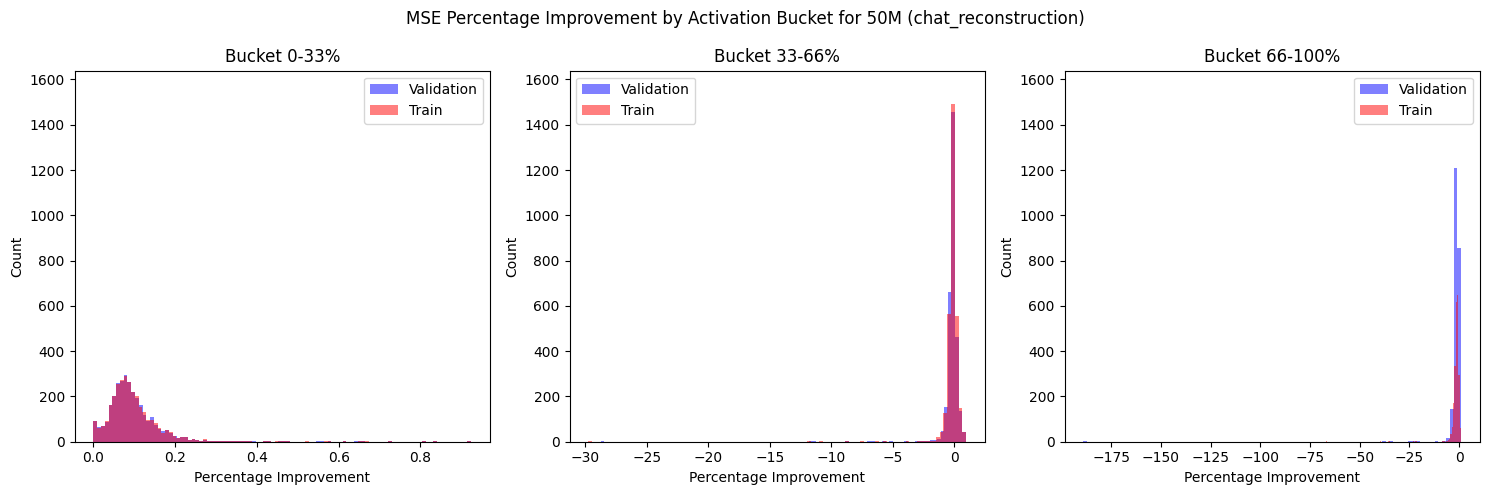

In [4]:
fig = plot_stats_mse(stats, "50M", computation="chat_reconstruction", show_train=True, show_val=True)
fig.savefig(PLOTS / "chat_reconstruction_mse.png")
fig.show()
fig = plot_stats_buckets(stats, "50M", computation="chat_reconstruction")
fig.savefig(PLOTS / "chat_reconstruction_mse_buckets.png")
fig.show()

Train split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00658
  Mean:   0.00023
  Median: 0.00012

Validation split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00671
  Mean:   0.00023
  Median: 0.00012


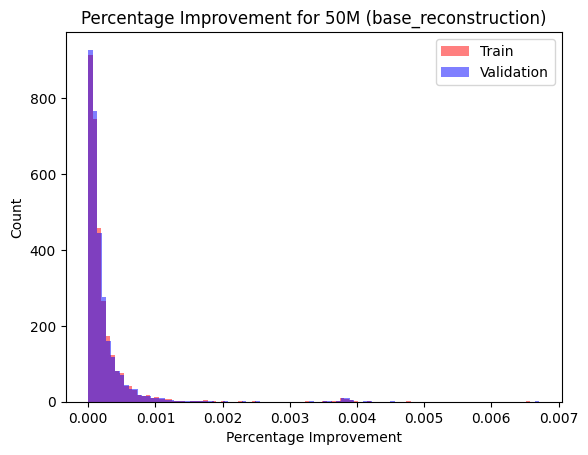

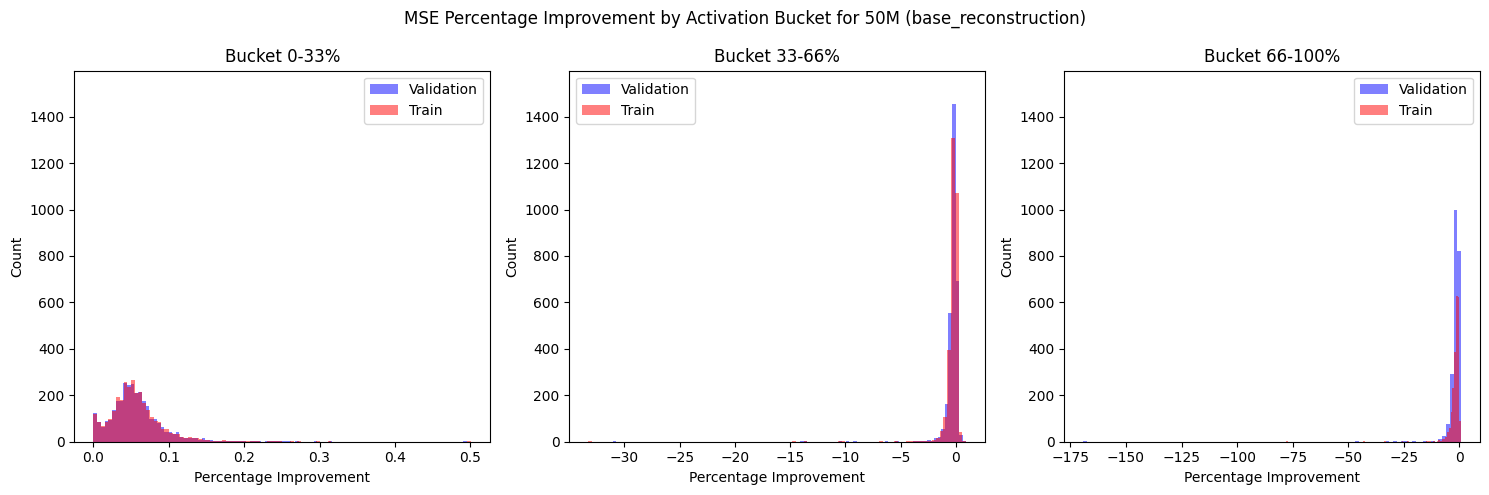

In [5]:
fig = plot_stats_mse(stats, "50M", computation="base_reconstruction")
fig.savefig(PLOTS / "base_reconstruction_mse.png")
fig.show()
fig = plot_stats_buckets(stats, "50M", computation="base_reconstruction")
fig.savefig(PLOTS / "base_reconstruction_mse_buckets.png")
fig.show()

Train split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00177
  Mean:   0.00006
  Median: 0.00005

Validation split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00176
  Mean:   0.00006
  Median: 0.00005


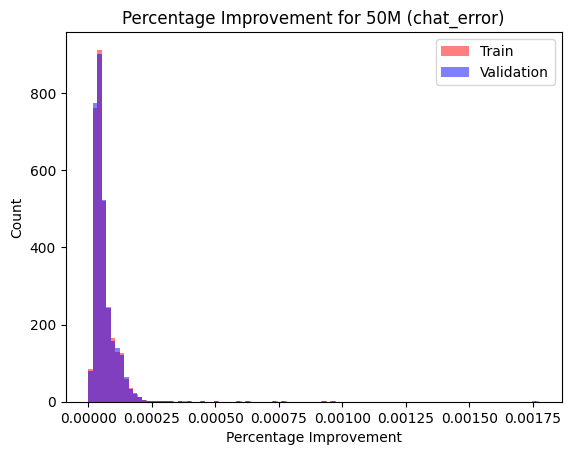

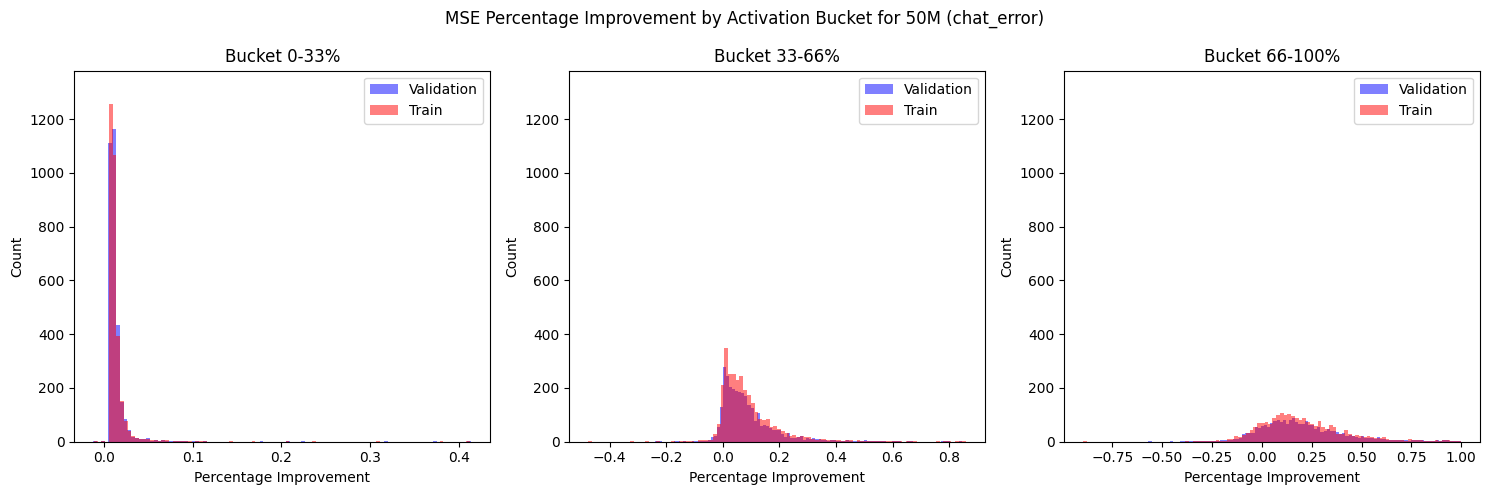

In [6]:
fig = plot_stats_mse(stats, "50M", computation="chat_error")
fig.savefig(PLOTS / "chat_error_mse.png")
fig.show()
fig = plot_stats_buckets(stats, "50M", computation="chat_error")
fig.savefig(PLOTS / "chat_error_mse_buckets.png")
fig.show()

Train split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00011
  Mean:   0.00001
  Median: 0.00001

Validation split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00011
  Mean:   0.00001
  Median: 0.00001


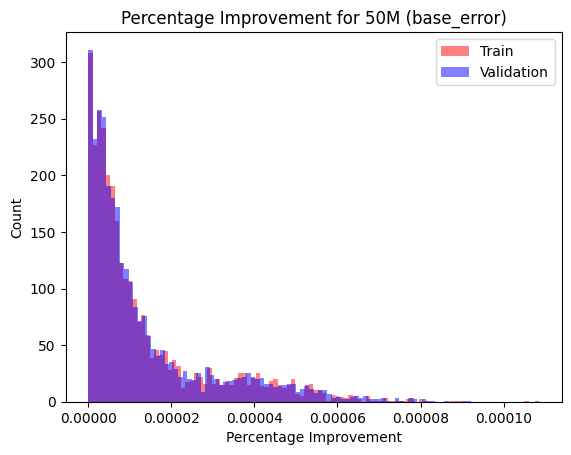

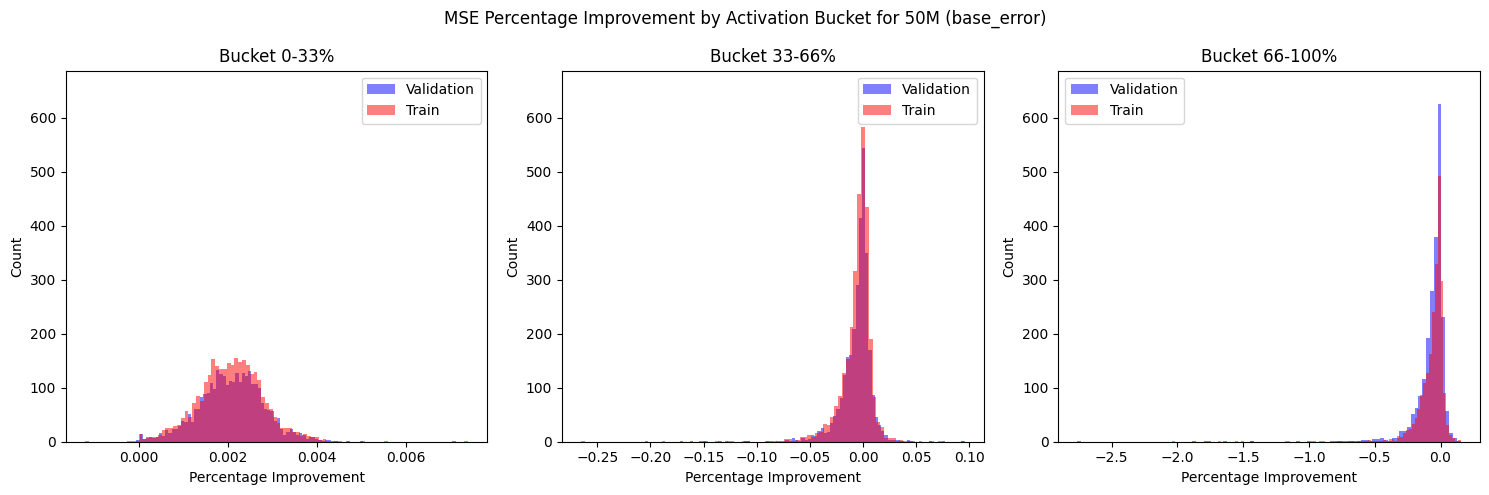

In [8]:
fig = plot_stats_mse(stats, "50M", computation="base_error")
fig.savefig(PLOTS / "base_error_mse.png")
fig.show()
fig = plot_stats_buckets(stats, "50M", computation="base_error")
fig.savefig(PLOTS / "base_error_mse_buckets.png")
fig.show()

Train split has 0 negative improvements
  Min:    0.00000
  Max:    0.00024
  Mean:   0.00004
  Median: 0.00003

Validation split has 0 negative improvements
  Min:    -0.00000
  Max:    0.00025
  Mean:   0.00004
  Median: 0.00003


<module 'matplotlib.pyplot' from '/workspace/julian/micromamba/envs/sof/lib/python3.11/site-packages/matplotlib/pyplot.py'>

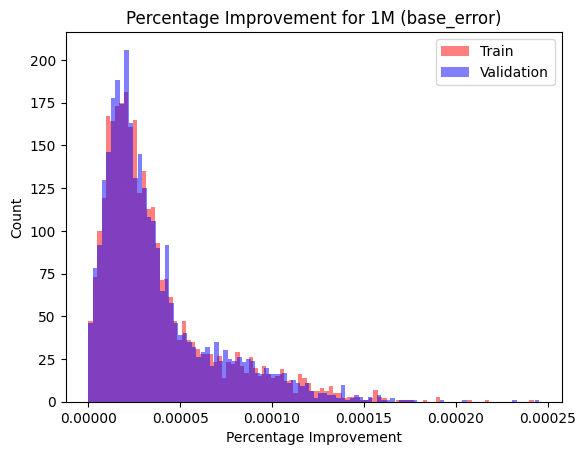

In [8]:
plot_stats_mse(stats, "1M", show_train=True, show_val=True)

Min beta: -3.1086 Count: 29.0
Max beta: 5.2246 Count: 15.0


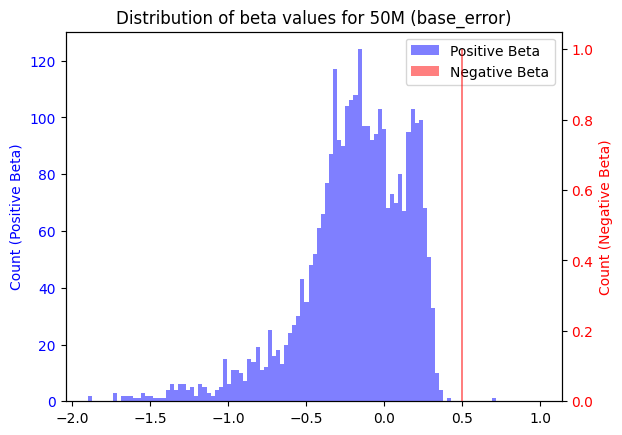

Min beta: -13.5834 Count: 29.0
Max beta: 4.9458 Count: 2450741.0


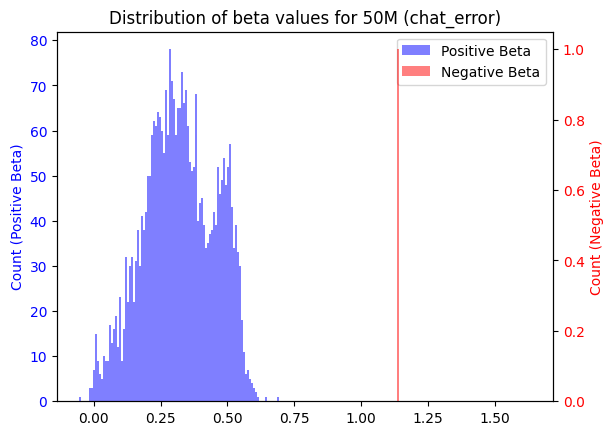

Min beta: -13.9705 Count: 799719.0
Max beta: 533.8265 Count: 29.0


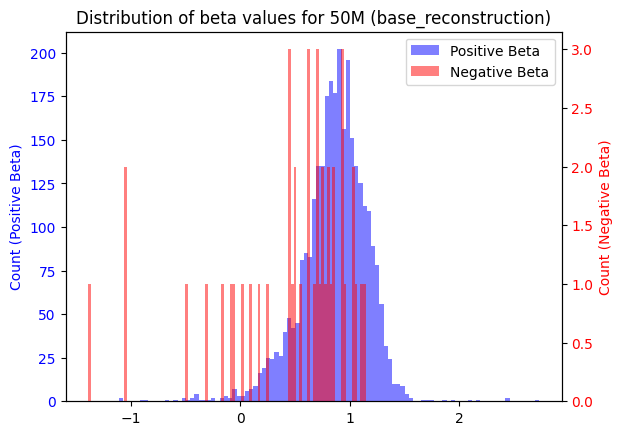

Min beta: -10.8772 Count: 799719.0
Max beta: 835.4606 Count: 156906.0


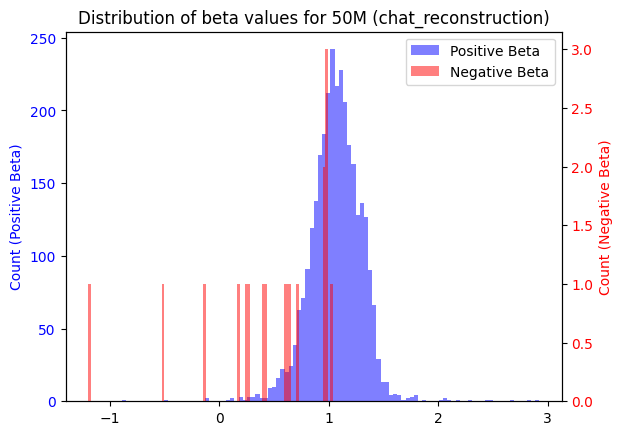

In [9]:
fig = plot_betas(betas, count_active, "50M", computation="base_error", log_scale=True)
fig.savefig(PLOTS / "50M_betas_base_error.png")
fig.show()
fig = plot_betas(betas, count_active, "50M", computation="chat_error", log_scale=True)
fig.savefig(PLOTS / "50M_betas_chat_error.png")
fig.show()
fig = plot_betas(betas, count_active, "50M", computation="base_reconstruction", log_scale=True)
fig.savefig(PLOTS / "50M_betas_base_reconstruction.png")
fig.show()
fig = plot_betas(betas, count_active, "50M", computation="chat_reconstruction", log_scale=True)
fig.savefig(PLOTS / "50M_betas.png")
fig.show()

/workspace/julian/repositories/representation-structure-comparison/notebooks/../tools/latent_scaler/utils.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  nan_idx_to_original_idx = th.arange(len(array))[~np.isnan(array)]


Max diff: 10.474788665771484  Counts: 29.0 29.0 Max Act: 57.041264
Median diff: 1.364823579788208
Mean diff: 1.3811203241348267
Min diff: 0.8278498649597168  Counts: 3186.0 3186.0 Max Act: 39.95906


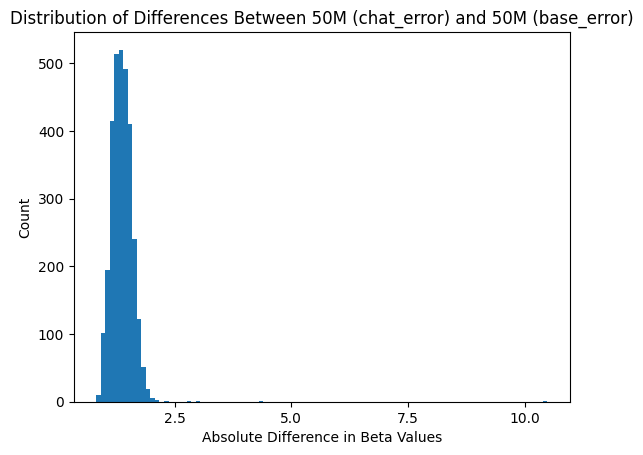

In [21]:
fig = plot_scalers_diff(betas, count_active, "50M", "chat_error", "50M", "base_error", log_scale_x=False)
fig.savefig(PLOTS / "50M_betas_error_diff.png")
fig.show()

/workspace/julian/repositories/representation-structure-comparison/notebooks/../tools/latent_scaler/utils.py:55: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  nan_idx_to_original_idx = th.arange(len(array))[~np.isnan(array)]


Max diff: 568.4783325195312  Counts: 156906.0 156906.0 Max Act: 70.230934
Median diff: 4.006103515625
Mean diff: 5.006718635559082
Min diff: 0.0026979446411132812  Counts: 450541.0 450541.0 Max Act: 58.324337


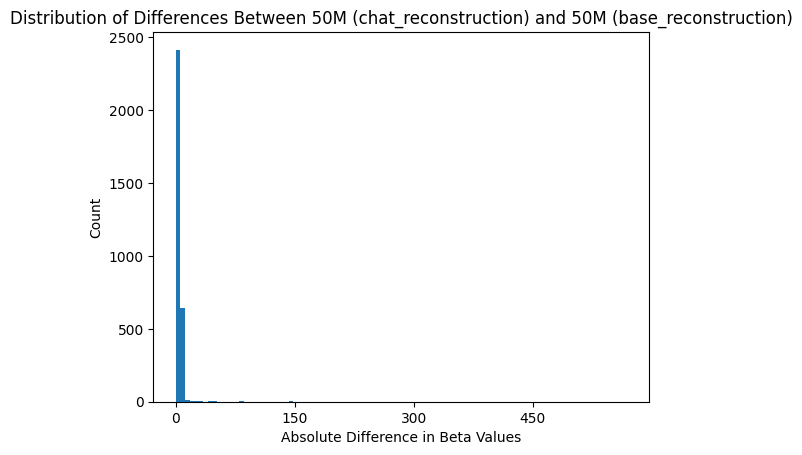

In [22]:
fig = plot_scalers_diff(betas, count_active, "50M", "chat_reconstruction", "50M", "base_reconstruction", log_scale_x=False)
fig.savefig(PLOTS / "50M_betas_reconstruction_diff.png")
fig.show()

# Identifying what happens during computation

We look at the MSE for each training sample for the overfit latent on the broken dataset.

In [10]:
def plot_mse_diff(stats, name, ylog: bool = False, idx: int = 0):
    mse_diff = (stats["mse_individual"] - stats["mse_before_individual"])[idx]
    # Calculate summary statistics for MSE differences
    min_diff = mse_diff.min().item()
    max_diff = mse_diff.max().item()
    mean_diff = mse_diff.mean().item()
    median_diff = float(np.median(mse_diff))
    # Count number of positive, negative and zero differences
    n_neg = (mse_diff < 0).sum().item()
    n_pos = (mse_diff > 0).sum().item() 
    n_zero = (mse_diff == 0).sum().item()
    
    print("MSE Difference Counts")
    print("--------------------------------")
    print(f"Negative: {n_neg:>12,d}")
    print(f"Positive: {n_pos:>12,d}")
    print(f"Zero:     {n_zero:>12,d}")
    print("--------------------------------")
    print("\nMSE Difference Summary Statistics")
    print("--------------------------------")
    print(f"Minimum:  {min_diff:>12,.2f}")
    print(f"Maximum:  {max_diff:>12,.2f}")
    print(f"Mean:     {mean_diff:>12,.2f}")
    print(f"Median:   {median_diff:>12,.2f}")
    print("--------------------------------")
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(mse_diff)), mse_diff, alpha=0.5, s=1)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.xlabel('Sample index')
    plt.ylabel('MSE difference')
    plt.title(f'{name} (mse_with_scaler - mse_without_scaler)')
    if ylog:
        plt.yscale('log')
    plt.show()

In [8]:
from pathlib import Path

base_path = Path("/workspace/data/results/closed_form_scalars/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04")

stats_ind_val = th.load(base_path / "/workspace/data/results/closed_form_scalars/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04/stats_base_error_N50000000_n_offset0_subset_top10_train_mse_indices_overfit_1M-2_EVAL_N3000000_n_offset0_train.pt")


/tmp/ipykernel_33794/1154327078.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stats_ind_val = th.load(base_path / "/workspace/data/results/closed_form_scalars/Butanium

MSE Difference Counts
--------------------------------
Negative:       18,071
Positive:        7,498
Zero:        2,974,431
--------------------------------

MSE Difference Summary Statistics
--------------------------------
Minimum:       -361.27
Maximum:        325.56
Mean:            -0.09
Median:           0.00
--------------------------------


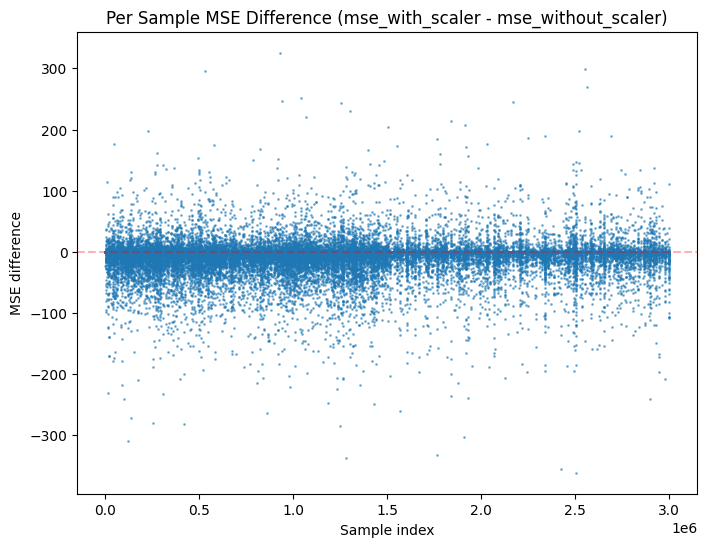

In [11]:
plot_mse_diff(stats_ind_val, "Per Sample MSE Difference", idx=0)

# Compare to Joint Scalers

In [5]:
from matplotlib.colors import LogNorm
from tools.utils import load_latent_df

In [6]:
df = load_latent_df()
joint_base_uselessness_score = df["base uselessness score"].iloc[chat_indices]
joint_scalers = np.exp(-joint_base_uselessness_score.to_numpy() + 1e-10)
joint_scalers.shape

(3176,)

In [10]:
betas_error = betas["base_error"]["50M"].numpy()

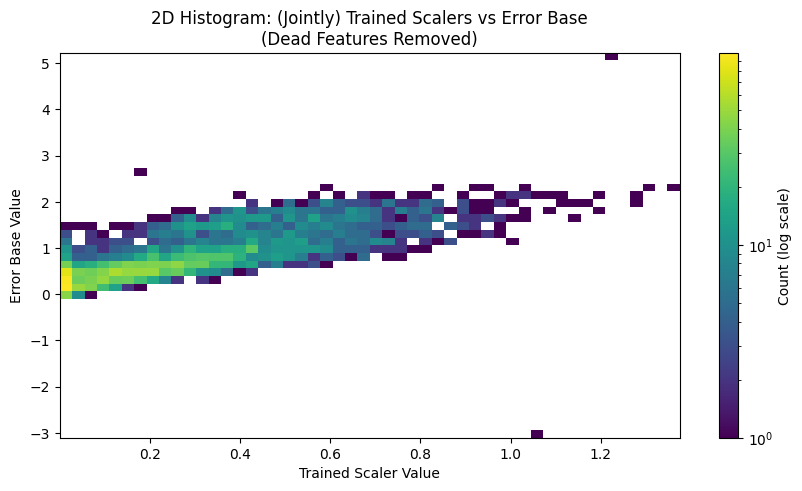

In [11]:
# Create 2D histogram of trained scalers vs error base, filtering outliers
plt.figure(figsize=(10,5))

# Get data and remove outliers
x_data = joint_scalers 
y_data = betas_error

nan_mask = ~np.isnan(x_data) & ~np.isnan(y_data)
x_data = x_data[nan_mask]
y_data = y_data[nan_mask]

plt.hist2d(x_data, y_data,
           bins=50, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Count (log scale)')
plt.xlabel('Trained Scaler Value')
plt.ylabel('Error Base Value')

plt.title('2D Histogram: (Jointly) Trained Scalers vs Error Base\n(Dead Features Removed)')
plt.savefig(PLOTS / "comparison_50M_betas_error_joint_scalers.png")
plt.show()